<a href="https://colab.research.google.com/github/maxruther/Emotion-Recognition/blob/main/Emotion_Recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# EMOTION RECOGNITION - ~~GROUP~~ FINAL PROJECT
## *Image Classification with CNN's*
### **by Max Ruther**~~, Xu Yifan, and Jason Lehmann~~

My final project for *CSC 578 (Neural Networks and Deep Learning)*. It was meant to be a group project, but my groupmates absented. This being so, please read the phrases 'we' and 'our' as 'I' and 'my' in the work that follows.

<br></br>

## DATASET AND TASK

**Dataset URL:** https://www.kaggle.com/datasets/ameyamote030/einterface-image-dataset/code

With this dataset of frontal faces expressing one of six emotions, we seek to classify the depicted emotions accurately through CNN's. The training set has 11,000+ samples and the six emotions are anger, disgust, fear, happiness, neutral, and sadness.

## SOME CHALLENGES FACED: `ImageDataGenerator`

This was our first time using the `ImageDataGenerator` outside of the guided homework assignment. Perhaps due to this novicial quality of our foray, we encountered these several challenges:

- **Data setup and loading into generators**:

  We experienced some struggle in setting up the large data files in a shared Google Drive, such that we could all load from there. There was an issue of corrupted data at one point. Perhaps more notably, this setup was our first time loading our own image data generators in a way where they 'flow from directories.'

- **Starting with too high an image size, for that `ImageDataGenerator` setting**:

  For the image size, we initially set it at 128, as these images were often 400 x 400 and we wanted to take advantage of that resolution. However, given that the training set contains as many as 11,000+ samples, we needed to drastically reduce that image size to 64, to cut training times down from 15 minutes to 6 or less.

- **Extracting labels from the generators:**

  Figuring out how to get the labels from our image data generator was difficult. The structure in our case was different than those from our class examples, seemingly.

- **Unawareness of the *shuffle* parameter setting complicated evaluation**

  Another challenge was realizing that the default setting for the ImageDataGenerator's *shuffle* parameter is **True**. This was highly consequential for evaluation executed outside of the `model.fit()` function. Evaluation done within the `model.fit()` behavior was somehow unaffected by a discrepancy of *shuffle* settings between our train and val generator

<br><

## IMPORTS

In [ ]:
!pip install -q -U keras-tuner

In [ ]:
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization

import zipfile
import numpy as np
import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import random
import os
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import load_img
import math
import time
import pickle

from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# For hypertuning:
import keras_tuner as kt
from tensorflow import keras

## DATA SETUP

#### Mount drive, to access data zip uploaded to you Drive

Uploading the data zip to drive and unzipping it there might be faster than unzipping it locally and uploading those directories.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#### Unzip the data zip (in my mounted Drive) into a dir in this Colab session

In [ ]:
# with zipfile.ZipFile('GroupProj_Files-6-10-815PM.zip', 'r') as zip_ref:
#   zip_ref.extractall('')

In [ ]:
with zipfile.ZipFile('drive/MyDrive/CSC_578/group_project/eINTERFACE_Image_Dataset.zip', 'r') as zip_ref:
  zip_ref.extractall('the_image_data')

## UTILITY FUNCTIONS

#### pickle_to_file

In [ ]:
def pickle_to_file(history, filename):
  file = open(filename, 'wb')
  pickle.dump(history, file)

  return

#### unpickle_from_file

In [ ]:
def unpickle_from_file(filename):
  file = open(filename, 'rb')
  history = pickle.load(file)
  file.close()

  return history

#### plot_history

From the class worksheet *exercise_flowers_with_data_augmentation_solution*, where it takes epochs as an argument in addition to history.

In [ ]:
def plot_history(history, epochs):
  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']

  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs_range = range(epochs)

  plt.figure(figsize=(8, 8))
  plt.subplot(1, 2, 1)
  plt.plot(epochs_range, acc, label='Training Accuracy')
  plt.plot(epochs_range, val_acc, label='Validation Accuracy')
  plt.legend(loc='lower right')
  plt.title('Training and Validation Accuracy')

  plt.subplot(1, 2, 2)
  plt.plot(epochs_range, loss, label='Training Loss')
  plt.plot(epochs_range, val_loss, label='Validation Loss')
  plt.legend(loc='upper right')
  plt.title('Training and Validation Loss')
  plt.show()

#### plot_confusion_matrix_heatmap

In [ ]:
def plot_confusion_matrix_heatmap(conf_matrix, target_names):
  fig, ax = plt.subplots(figsize=(8,4))
  sns.heatmap(conf_matrix, annot=True, cmap='Reds', fmt='g', ax=ax)
  ax.set_xticklabels(target_names)
  ax.set_yticklabels(target_names, rotation=0)
  ax.set_title('Confusion Matrix Heatmap')
  plt.show()

## DATA LOADING

### Generator Parameters

In [ ]:
pixels = 128
IMAGE_SIZE = (pixels, pixels)
IMAGE_CHANNELS=3
BATCH_SIZE = 256

INPUT_SHAPE = (pixels, pixels, IMAGE_CHANNELS)

### Creating Generators

In [ ]:

os.path.dirname('the_image_data/eINTERFACE_2021_Image')

'the_image_data'

In [ ]:
base_dir = 'the_image_data/eINTERFACE_2021_Image'
train_dir = os.path.join(base_dir, 'train')
validate_dir = os.path.join(base_dir, 'val')
test_dir = os.path.join(base_dir, 'test')


In [ ]:
train_image_generator = ImageDataGenerator(rescale=1./255)
validation_image_generator = ImageDataGenerator(rescale=1./255)
test_image_generator = ImageDataGenerator(rescale=1./255)

In [ ]:
train_data_gen = train_image_generator.flow_from_directory(
    train_dir,
    target_size=(128, 128),
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

Found 11475 images belonging to 6 classes.


In [ ]:
val_data_gen = validation_image_generator.flow_from_directory(
    validate_dir,
    target_size=(128, 128),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

Found 1433 images belonging to 6 classes.


In [ ]:
test_data_gen = test_image_generator.flow_from_directory(
    test_dir,
    target_size=(128, 128),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

Found 1438 images belonging to 6 classes.


In [ ]:
TRAIN_SIZE = train_data_gen.samples
VAL_SIZE = val_data_gen.samples
TEST_SIZE = test_data_gen.samples

In [ ]:
print(TRAIN_SIZE)
print(VAL_SIZE)
print(TEST_SIZE)

11475
1433
1438


In [ ]:
print(np.ceil(TRAIN_SIZE/BATCH_SIZE))
print(np.ceil(VAL_SIZE/BATCH_SIZE))
print(np.ceil(TEST_SIZE/BATCH_SIZE))

45.0
6.0
6.0


## VISUALIZING TRAINING IMAGES

In [ ]:
sample_training_images, _ = next(train_data_gen)

In [ ]:
def plotImages(images_arr):
    fig, axes = plt.subplots(2, 2, figsize=(5, 5))
    axes = axes.flatten()
    for img, ax in zip(images_arr, axes):
        ax.imshow(img)
    plt.tight_layout()
    plt.show()

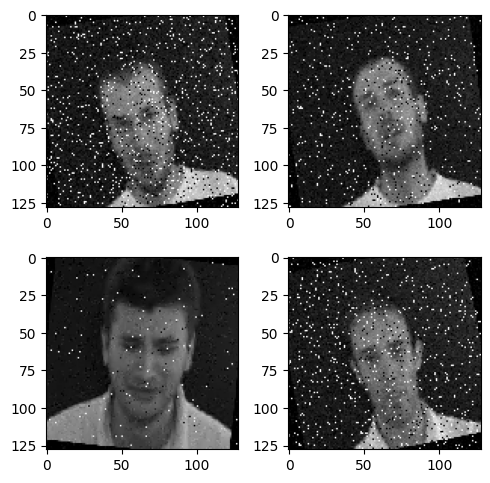

In [ ]:
plotImages(sample_training_images[:4])

## MODELING

#### Model 1 - A Borrowed CNN

A CNN architecture that we are here borrowing from a Kaggler, as we hammer out issues with out model.

(**UPDATE**: We have hammered out the issue- we were setting up the loss function incorrectly in our model constructions. The models that follow this one are more original and superior to this one, but we will leave this borrowed one in here to document the course of this analysis.)

##### Create Model

In [ ]:
classifier = Sequential()

# Step 1 - Convolution
classifier.add(Conv2D(16, (3, 3), input_shape = (128, 128, 3), activation = 'relu'))

# Step 2 - Pooling
classifier.add(MaxPooling2D(pool_size = (2, 2)))

# Adding a second convolutional layer
classifier.add(Conv2D(32, (3, 3), activation = 'relu'))
classifier.add(MaxPooling2D(pool_size = (2, 2)))



# Step 3 - Flattening
classifier.add(Flatten())

# Step 4 - Full connection
classifier.add(Dense(units = 128, activation = 'relu'))

classifier.add(Dense(units = 6, activation = 'softmax'))

# Compiling the CNN
classifier.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])

classifier.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 126, 126, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2  (None, 63, 63, 16)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 61, 61, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 30, 30, 32)        0         
 g2D)                                                            
                                                                 
 flatten (Flatten)           (None, 28800)             0         
                                                                 
 dense (Dense)               (None, 128)               3

##### Train Model

Done just once, because it was long. The feedback is copied below in the text cell that follows this code cell.

In [ ]:
# train_time_start = time.time()

# history = classifier.fit(train_data_gen,
#                          epochs = 5,
#                          validation_data = val_data_gen)

# train_time_classifier = time.time() - train_time_start
# print(f"Training time: {train_time_classifier} seconds")

The above training was long and only done once, so it's feedback was copied here:

```
Epoch 1/5
45/45 [==============================] - 185s 4s/step - loss: 1.8984 - accuracy: 0.1971 - val_loss: 1.7837 - val_accuracy: 0.2470
Epoch 2/5
45/45 [==============================] - 176s 4s/step - loss: 1.7055 - accuracy: 0.3032 - val_loss: 1.5715 - val_accuracy: 0.3803
Epoch 3/5
45/45 [==============================] - 214s 5s/step - loss: 1.4519 - accuracy: 0.4276 - val_loss: 1.4185 - val_accuracy: 0.4578
Epoch 4/5
45/45 [==============================] - 184s 4s/step - loss: 1.2208 - accuracy: 0.5347 - val_loss: 1.3537 - val_accuracy: 0.4669
Epoch 5/5
45/45 [==============================] - 180s 4s/step - loss: 1.0165 - accuracy: 0.6315 - val_loss: 1.1608 - val_accuracy: 0.5625
Training time: 1009.8315932750702 seconds
```



In [ ]:
# classifier.save('borrowed_cnn.keras')
# pickle_to_file(history, 'borrowed_cnn_history.pickle')

##### (Load model from file)

For when training is skipped

In [ ]:
classifer = tf.keras.models.load_model('borrowed_cnn.keras')
history_classifier = unpickle_from_file('borrowed_cnn_history.pickle')

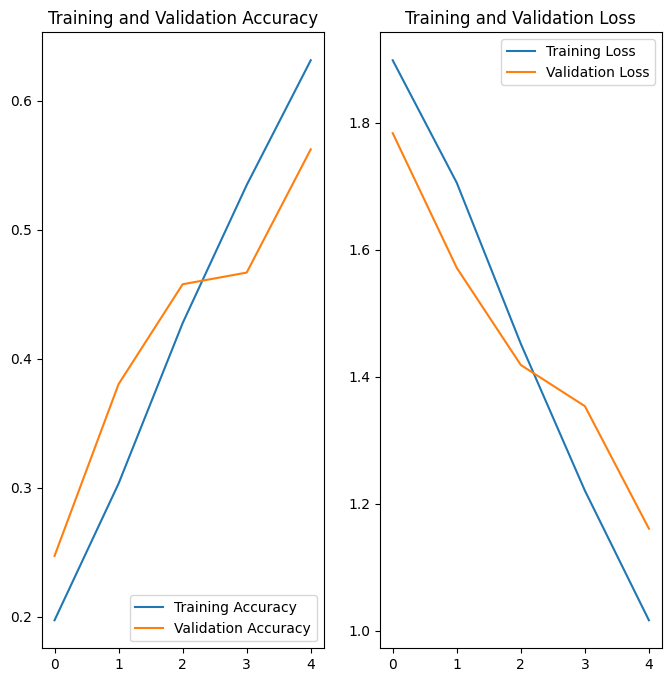

In [ ]:
plot_history(history_classifier, 5)

##### Discussion

This model would clearly benefit from more epochs, but it took 15+ minutes just to train it on 5. We next raise our batch size to try to mitigate this issue of overlong training.

### RAISING BATCH SIZE

For faster training. Also setting steps-per-epoch that accord with the training, validation, and testing generators.

In [ ]:
BATCH_SIZE = 2048

In [ ]:
train_data_gen = train_image_generator.flow_from_directory(
    train_dir,
    target_size=(128, 128),
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

Found 11475 images belonging to 6 classes.


In [ ]:
val_data_gen = validation_image_generator.flow_from_directory(
    validate_dir,
    target_size=(128, 128),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

Found 1433 images belonging to 6 classes.


In [ ]:
test_data_gen = test_image_generator.flow_from_directory(
    test_dir,
    target_size=(128, 128),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

Found 1438 images belonging to 6 classes.


In [ ]:
train_steps = np.ceil(TRAIN_SIZE/BATCH_SIZE)
val_steps = np.ceil(VAL_SIZE/BATCH_SIZE)
test_steps = np.ceil(TEST_SIZE/BATCH_SIZE)

print(train_steps)
print(val_steps)
print(test_steps)

6.0
1.0
1.0


#### Model 2 - CNN from Project 6

Using the architecture suggested in Project 6

##### Create Model

In [ ]:
model_CNN_P6 = Sequential([
    Conv2D(8, (3,3), padding='same', activation=tf.nn.tanh,
           input_shape=INPUT_SHAPE),
    MaxPooling2D(pool_size=(2, 2), strides=2),

    Conv2D(16, (3,3), padding='same', activation=tf.nn.tanh),
    MaxPooling2D(pool_size=(2, 2), strides=2),

    Conv2D(32, (3,3), padding='same', activation=tf.nn.tanh),
    MaxPooling2D(pool_size=(2, 2), strides=2),

    Flatten(),
    Dense(128, activation=tf.nn.relu),
    Dense(64, activation=tf.nn.relu),
    Dense(32, activation=tf.nn.relu),
    Dense(6, activation='softmax')
])
model_CNN_P6._name = 'M2.BatchSz2048xCNNp6'
model_CNN_P6.summary()

model_CNN_P6.compile(optimizer='adam',
              loss= 'categorical_crossentropy',
              metrics=['accuracy'])

Model: "M2.BatchSz2048xCNNp6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 128, 128, 8)       224       
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 64, 64, 8)         0         
 g2D)                                                            
                                                                 
 conv2d_3 (Conv2D)           (None, 64, 64, 16)        1168      
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 32, 32, 16)        0         
 g2D)                                                            
                                                                 
 conv2d_4 (Conv2D)           (None, 32, 32, 32)        4640      
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 16, 16, 32

##### Train Model

In [ ]:
# train_time_start = time.time()

# history = model_CNN_P6.fit(train_data_gen,
#                          epochs = 5,
#                          validation_data = val_data_gen)

# train_time_CNN_P6 = time.time() - train_time_start
# print(f"Training time: {train_time_CNN_P6} seconds")

The above training was long and only done once, so it's feedback was copied here:

```
Epoch 1/5
6/6 [==============================] - 165s 26s/step - loss: 1.8030 - accuracy: 0.1691 - val_loss: 1.7855 - val_accuracy: 0.1982
Epoch 2/5
6/6 [==============================] - 145s 25s/step - loss: 1.7690 - accuracy: 0.2393 - val_loss: 1.7398 - val_accuracy: 0.2973
Epoch 3/5
6/6 [==============================] - 146s 22s/step - loss: 1.7002 - accuracy: 0.3160 - val_loss: 1.6274 - val_accuracy: 0.3350
Epoch 4/5
6/6 [==============================] - 147s 23s/step - loss: 1.5996 - accuracy: 0.3427 - val_loss: 1.5682 - val_accuracy: 0.3447
Epoch 5/5
6/6 [==============================] - 155s 24s/step - loss: 1.5190 - accuracy: 0.3789 - val_loss: 1.4976 - val_accuracy: 0.3950
Training time: 809.6712601184845 seconds
```



In [ ]:
# model_CNN_P6.save('CNN_P6.keras')
# pickle_to_file(history, 'CNN_P6_history.pickle')

##### (Load model from file)

For when training is skipped.

In [ ]:
model_CNN_P6 = tf.keras.models.load_model('CNN_P6.keras')
history_CNN_P6 = unpickle_from_file('CNN_P6_history.pickle')

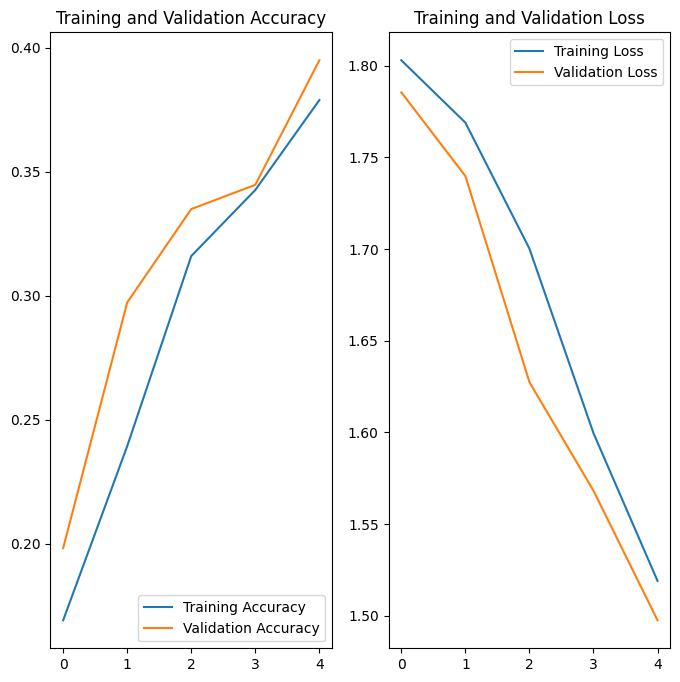

In [ ]:
plot_history(history_CNN_P6, 5)

##### Discussion

Raising the batch size might have cut the training time down from ~1000 seconds to 809, but I'm looking for a much more drastic reduction. In the next section, I explore reducing the image size as a means of doing this.

### LOWERING IMAGE_SIZE

Lowering IMAGE_SIZE to 64 from 128. Counter to my effort to speed things up here, I'm also lowering BATCH_SIZE to 64, because raising it to ~2000 didn't seem to do much, anyway.

In [ ]:
pixels = 64
IMAGE_SIZE = (pixels, pixels)
IMAGE_CHANNELS=3
BATCH_SIZE = 64

INPUT_SHAPE = (pixels, pixels, IMAGE_CHANNELS)

In [ ]:
train_data_gen = train_image_generator.flow_from_directory(
    train_dir,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

Found 11475 images belonging to 6 classes.


In [ ]:
val_data_gen = validation_image_generator.flow_from_directory(
    validate_dir,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

Found 1433 images belonging to 6 classes.


In [ ]:
test_data_gen = test_image_generator.flow_from_directory(
    test_dir,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

Found 1438 images belonging to 6 classes.


In [ ]:
TRAIN_SIZE = train_data_gen.samples
VAL_SIZE = val_data_gen.samples
TEST_SIZE = test_data_gen.samples

In [ ]:
print(TRAIN_SIZE)
print(VAL_SIZE)
print(TEST_SIZE)

11475
1433
1438


In [ ]:
train_steps = np.ceil(TRAIN_SIZE/BATCH_SIZE)
val_steps = np.ceil(VAL_SIZE/BATCH_SIZE)
test_steps = np.ceil(TEST_SIZE/BATCH_SIZE)

print(train_steps)
print(val_steps)
print(test_steps)

180.0
23.0
23.0


#### Visualizing Images

Now that we are using 64x64 instead of 128x128 images, it might be helpful to visualized a few randomly picked images from this lower resolution training set we've created.

In [ ]:
sample_training_images, _ = next(train_data_gen)

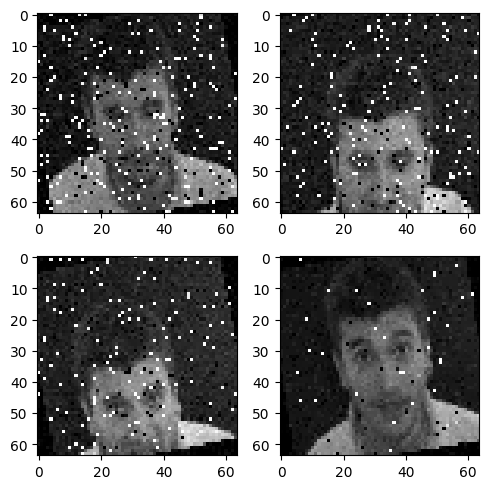

In [ ]:
plotImages(sample_training_images[:4])

#### Model 3 - CNN from P6, on reduced imgs

##### Create Model

In [ ]:
model_CNN_quick_2 = Sequential([
    Conv2D(8, (3,3), padding='same', activation=tf.nn.tanh,
           input_shape=INPUT_SHAPE),
    MaxPooling2D(pool_size=(2, 2), strides=2),

    Conv2D(16, (3,3), padding='same', activation=tf.nn.tanh),
    MaxPooling2D(pool_size=(2, 2), strides=2),

    Conv2D(32, (3,3), padding='same', activation=tf.nn.tanh),
    MaxPooling2D(pool_size=(2, 2), strides=2),

    Flatten(),
    Dense(128, activation=tf.nn.relu),
    Dense(64, activation=tf.nn.relu),
    Dense(32, activation=tf.nn.relu),
    Dense(6, activation='softmax')
])
model_CNN_quick_2._name = 'M3.LowerImgSz'
model_CNN_quick_2.summary()

model_CNN_quick_2.compile(optimizer='adam',
              loss= 'categorical_crossentropy',
              metrics=['accuracy'])

Model: "M3.LowerImgSz"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 64, 64, 8)         224       
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 32, 32, 8)         0         
 g2D)                                                            
                                                                 
 conv2d_6 (Conv2D)           (None, 32, 32, 16)        1168      
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 16, 16, 16)        0         
 g2D)                                                            
                                                                 
 conv2d_7 (Conv2D)           (None, 16, 16, 32)        4640      
                                                                 
 max_pooling2d_7 (MaxPoolin  (None, 8, 8, 32)        

##### Train Model

In [ ]:
# train_time_start = time.time()

# history = model_CNN_quick_2.fit(train_data_gen,
#                               epochs = 5,
#                               steps_per_epoch = train_steps,
#                               validation_data = val_data_gen)

# train_time_CNN_quick_2 = time.time() - train_time_start
# print(f"Training time: {train_time_CNN_quick_2} seconds")



```
Epoch 1/5
180/180 [==============================] - 55s 298ms/step - loss: 1.4453 - accuracy: 0.3927 - val_loss: 1.1809 - val_accuracy: 0.5248
Epoch 2/5
180/180 [==============================] - 49s 273ms/step - loss: 0.9414 - accuracy: 0.6218 - val_loss: 0.8462 - val_accuracy: 0.6469
Epoch 3/5
180/180 [==============================] - 49s 270ms/step - loss: 0.6587 - accuracy: 0.7481 - val_loss: 0.6537 - val_accuracy: 0.7669
Epoch 4/5
180/180 [==============================] - 51s 284ms/step - loss: 0.4832 - accuracy: 0.8222 - val_loss: 0.5128 - val_accuracy: 0.8081
Epoch 5/5
180/180 [==============================] - 60s 334ms/step - loss: 0.3746 - accuracy: 0.8649 - val_loss: 0.4400 - val_accuracy: 0.8360
Training time: 286.3510799407959 seconds
```



In [ ]:
# model_CNN_quick_2.save('model_CNN_quick_2.keras')
# pickle_to_file(history, 'model_CNN_quick_2_history.pickle')

##### (Load model from file)

In [ ]:
model_CNN_quick_2 = tf.keras.models.load_model('model_CNN_quick_2.keras')
history_CNN_quick_2 = unpickle_from_file('model_CNN_quick_2_history.pickle')

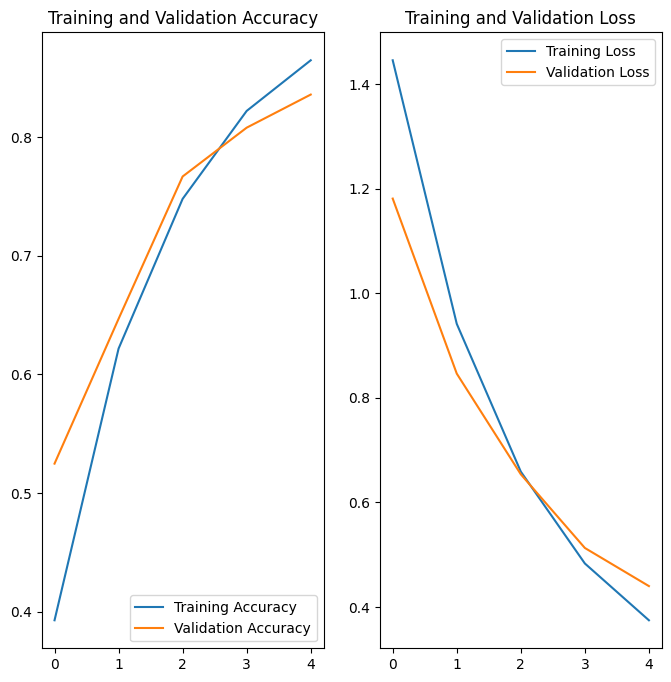

In [ ]:
plot_history(history_CNN_quick_2, 5)

##### Discussion

This was successful in drastically reducing the training time. It went from ~14 minutes to 5. And we have the highest accuracy so far here.

### RAISING BATCH SIZE AGAIN

Oops! In the previous section where I lowered the image size, I also opted to lowered the batch size back down, from 2048 to 64. I did this because I thought it was a trivial improvement, but some prolongued hypertuning has changed my mind.

In [ ]:
BATCH_SIZE = 2048

In [ ]:
IMAGE_SIZE

(64, 64)

In [ ]:
train_data_gen = train_image_generator.flow_from_directory(
    train_dir,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

Found 11475 images belonging to 6 classes.


In [ ]:
val_data_gen = validation_image_generator.flow_from_directory(
    validate_dir,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

Found 1433 images belonging to 6 classes.


In [ ]:
test_data_gen = test_image_generator.flow_from_directory(
    test_dir,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

Found 1438 images belonging to 6 classes.


In [ ]:
train_steps = np.ceil(TRAIN_SIZE/BATCH_SIZE)
val_steps = np.ceil(VAL_SIZE/BATCH_SIZE)
test_steps = np.ceil(TEST_SIZE/BATCH_SIZE)

print(train_steps)
print(val_steps)
print(test_steps)

6.0
1.0
1.0


#### Model 4 - Low ImageSize, High BatchSize

##### Create Model

In [ ]:
model_4 = Sequential([
    Conv2D(8, (3,3), padding='same', activation=tf.nn.tanh,
           input_shape=INPUT_SHAPE),
    MaxPooling2D(pool_size=(2, 2), strides=2),

    Conv2D(16, (3,3), padding='same', activation=tf.nn.tanh),
    MaxPooling2D(pool_size=(2, 2), strides=2),

    Conv2D(32, (3,3), padding='same', activation=tf.nn.tanh),
    MaxPooling2D(pool_size=(2, 2), strides=2),

    Flatten(),
    Dense(128, activation=tf.nn.relu),
    Dense(64, activation=tf.nn.relu),
    Dense(32, activation=tf.nn.relu),
    Dense(6, activation='softmax')
])
model_4._name = 'M4.LowImgSzHighBatch'
model_4.summary()

model_4.compile(optimizer='adam',
              loss= 'categorical_crossentropy',
              metrics=['accuracy'])

Model: "M4.LowImgSzHighBatch"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 64, 64, 8)         224       
                                                                 
 max_pooling2d_8 (MaxPoolin  (None, 32, 32, 8)         0         
 g2D)                                                            
                                                                 
 conv2d_9 (Conv2D)           (None, 32, 32, 16)        1168      
                                                                 
 max_pooling2d_9 (MaxPoolin  (None, 16, 16, 16)        0         
 g2D)                                                            
                                                                 
 conv2d_10 (Conv2D)          (None, 16, 16, 32)        4640      
                                                                 
 max_pooling2d_10 (MaxPooli  (None, 8, 8, 32) 

##### Train model

In [ ]:
# train_time_start = time.time()

# history = model_4.fit(train_data_gen,
#                       steps_per_epoch = train_steps,
#                       epochs = 5,
#                       validation_data = val_data_gen,
#                       validation_steps=val_steps)

# train_time_model_4 = time.time() - train_time_start
# print(f"Training time: {train_time_model_4} seconds")

The above training was long and only done once, so it's feedback was copied here:

```
Epoch 1/5
6/6 [==============================] - 61s 9s/step - loss: 1.7713 - accuracy: 0.2247 - val_loss: 1.7210 - val_accuracy: 0.3175
Epoch 2/5
6/6 [==============================] - 52s 8s/step - loss: 1.6725 - accuracy: 0.3321 - val_loss: 1.5971 - val_accuracy: 0.3496
Epoch 3/5
6/6 [==============================] - 54s 8s/step - loss: 1.5681 - accuracy: 0.3655 - val_loss: 1.5303 - val_accuracy: 0.3726
Epoch 4/5
6/6 [==============================] - 59s 9s/step - loss: 1.4902 - accuracy: 0.3939 - val_loss: 1.4671 - val_accuracy: 0.4047
Epoch 5/5
6/6 [==============================] - 51s 8s/step - loss: 1.4200 - accuracy: 0.4171 - val_loss: 1.4163 - val_accuracy: 0.4194
Training time: 340.5573868751526 seconds
```



In [ ]:
# model_4.save('model_4.keras')
# pickle_to_file(history, 'model_4_history.pickle')

##### (Load model from file)

For when training is skipped.

In [ ]:
model_4 = tf.keras.models.load_model('model_4.keras')
history_model_4 = unpickle_from_file('model_4_history.pickle')

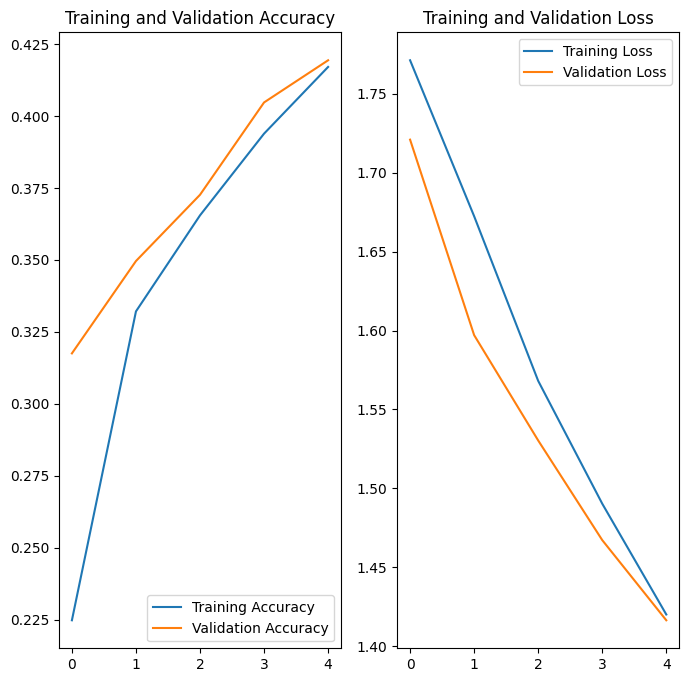

In [ ]:
plot_history(history_model_4, 5)

##### Discussion

This training took longer than the previous one, and was far less accurate. So before moving forward to hypertuning, I will here undo this section's batch size adjustments

#### Undoing this batch size adjustment


In [ ]:
pixels = 64
IMAGE_SIZE = (pixels, pixels)
IMAGE_CHANNELS=3
BATCH_SIZE = 64

INPUT_SHAPE = (pixels, pixels, IMAGE_CHANNELS)

In [ ]:
train_data_gen = train_image_generator.flow_from_directory(
    train_dir,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

Found 11475 images belonging to 6 classes.


In [ ]:
val_data_gen = validation_image_generator.flow_from_directory(
    validate_dir,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

Found 1433 images belonging to 6 classes.


In [ ]:
test_data_gen = test_image_generator.flow_from_directory(
    test_dir,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

Found 1438 images belonging to 6 classes.


In [ ]:
TRAIN_SIZE = train_data_gen.samples
VAL_SIZE = val_data_gen.samples
TEST_SIZE = test_data_gen.samples

print(TRAIN_SIZE)
print(VAL_SIZE)
print(TEST_SIZE)

11475
1433
1438


In [ ]:
train_steps = np.ceil(TRAIN_SIZE/BATCH_SIZE)
val_steps = np.ceil(VAL_SIZE/BATCH_SIZE)
test_steps = np.ceil(TEST_SIZE/BATCH_SIZE)

print(train_steps)
print(val_steps)
print(test_steps)

180.0
23.0
23.0


## HYPERTUNING

### Model 5 - Hypertuning our CNN

Hypertuning a CNN on our reduced-size images, since it performed best thereon.

#### Create model_builder

In [ ]:
def model_builder(hp):

  # Hypertuning widths of second and third dense layers
  hp_units_dl2 = hp.Int('units - l2', min_value=64, max_value=128, step=64)
  hp_units_dl3 = hp.Int('units - l3', min_value=32, max_value=64, step=32)

  # Hypertuning learning rate of Adam optimizer (in model compilation)
  hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3])

  model = tf.keras.Sequential()

  model = Sequential([
    Conv2D(8, (3,3), padding='same', activation=tf.nn.tanh,
           input_shape=INPUT_SHAPE),
    MaxPooling2D(pool_size=(2, 2), strides=2),

    Conv2D(16, (3,3), padding='same', activation=tf.nn.tanh),
    MaxPooling2D(pool_size=(2, 2), strides=2),

    Conv2D(32, (3,3), padding='same', activation=tf.nn.tanh),
    MaxPooling2D(pool_size=(2, 2), strides=2),

    Flatten(),
    Dense(128, activation=tf.nn.relu),
    Dense(units=hp_units_dl2, activation=tf.nn.relu),
    Dense(units=hp_units_dl3, activation=tf.nn.relu),
    Dense(6, activation='softmax')
    ])

  model.compile(optimizer=keras.optimizers.Adam(learning_rate=hp_learning_rate),
              loss= 'categorical_crossentropy',
              metrics=['accuracy'])

  return model

#### Instantiate the tuner

In [ ]:
# # Delete existing tuner dir (if needed)
# %rm -rf ./Tuning_GroupProj/M4

In [ ]:
tuner = kt.Hyperband(model_builder,
                     objective='val_accuracy',
                     max_epochs=10,
                     factor=3,
                     directory='Tuning_GroupProj',
                     project_name='M4')

Creating a callback for early stopping

In [ ]:
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

#### Hypertune with tuner

Though leaving steps-per-epoch unspecified led to our most accurate model, it is prohibitively slow to do so for hypertuning. So instead, I will specify this value, as I did for Model 3.

In [ ]:
# tuner.search(train_data_gen,
#              steps_per_epoch=train_steps,
#              validation_data=val_data_gen,
#              validation_steps=val_steps,
#              epochs=5,
#              callbacks=[stop_early])


# # Get the optimal hyperparameters
# best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]



Trial 1 Complete [00h 02m 26s]
val_accuracy: 0.16748081147670746

Best val_accuracy So Far: 0.16748081147670746
Total elapsed time: 00h 02m 26s

Search: Running Trial #2

Value             |Best Value So Far |Hyperparameter
128               |64                |units - l2
32                |32                |units - l3
0.01              |0.01              |learning_rate
2                 |2                 |tuner/epochs
0                 |0                 |tuner/initial_epoch
2                 |2                 |tuner/bracket
0                 |0                 |tuner/round

Epoch 1/2
 58/180 [========>.....................] - ETA: 48s - loss: 1.9682 - accuracy: 0.1775

KeyboardInterrupt: 

In [ ]:
# print(f"""
# The hyperparameter search is complete. The optimal parameters of those tested are:

# Node count in 2nd hidden layer: {best_hps.get('units - l2')}
# Node count in 3rd hidden layer: {best_hps.get('units - l3')}
# Learning rate of Adam optimizer: {best_hps.get('learning_rate')}
# """)

The tuner has determined that raising the second hidden layer's count from 64 to 128 (while keeping the other two parameters tested here the same as original) is the optimal choice of the eight tested here.

#### Create and train model with optimal hyperparameters found

In [ ]:
# model_hp = tuner.hypermodel.build(best_hps)
# model_hp._name = 'M5.Hypertuned'
# model_hp.summary()

# history_hp = model_hp.fit(train_data_gen,
#                               steps_per_epoch=train_steps,
#                               validation_data=val_data_gen,
#                               validation_steps=val_steps,
#                               epochs=5)




```
Model: "M5.Hypertuned"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
=================================================================
 conv2d_3 (Conv2D)           (None, 64, 64, 8)         224       
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 32, 32, 8)         0         
 g2D)                                                            
                                                                 
 conv2d_4 (Conv2D)           (None, 32, 32, 16)        1168      
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 16, 16, 16)        0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 16, 16, 32)        4640      
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 8, 8, 32)          0         
 g2D)                                                            
                                                                 
 flatten_1 (Flatten)         (None, 2048)              0         
                                                                 
 dense_4 (Dense)             (None, 128)               262272    
                                                                 
 dense_5 (Dense)             (None, 128)               16512     
                                                                 
 dense_6 (Dense)             (None, 32)                4128      
                                                                 
 dense_7 (Dense)             (None, 6)                 198       
                                                                 
=================================================================
Total params: 289142 (1.10 MB)
Trainable params: 289142 (1.10 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/5
180/180 [==============================] - 57s 304ms/step - loss: 1.5116 - accuracy: 0.3633 - val_loss: 1.2323 - val_accuracy: 0.5150
Epoch 2/5
180/180 [==============================] - 53s 293ms/step - loss: 0.9592 - accuracy: 0.6139 - val_loss: 0.8363 - val_accuracy: 0.6748
Epoch 3/5
180/180 [==============================] - 50s 280ms/step - loss: 0.6720 - accuracy: 0.7355 - val_loss: 0.6400 - val_accuracy: 0.7516
Epoch 4/5
180/180 [==============================] - 53s 292ms/step - loss: 0.5064 - accuracy: 0.8110 - val_loss: 0.5191 - val_accuracy: 0.8158
Epoch 5/5
180/180 [==============================] - 53s 297ms/step - loss: 0.3966 - accuracy: 0.8536 - val_loss: 0.4781 - val_accuracy: 0.8241
```



In [ ]:
# model_hp.save('model_hp.keras')
# pickle_to_file(history, 'model_hp_history.pickle')

#### (Load model from file)

In [ ]:
model_hp = tf.keras.models.load_model('model_hp.keras')
history_hp = unpickle_from_file('model_hp_history.pickle')

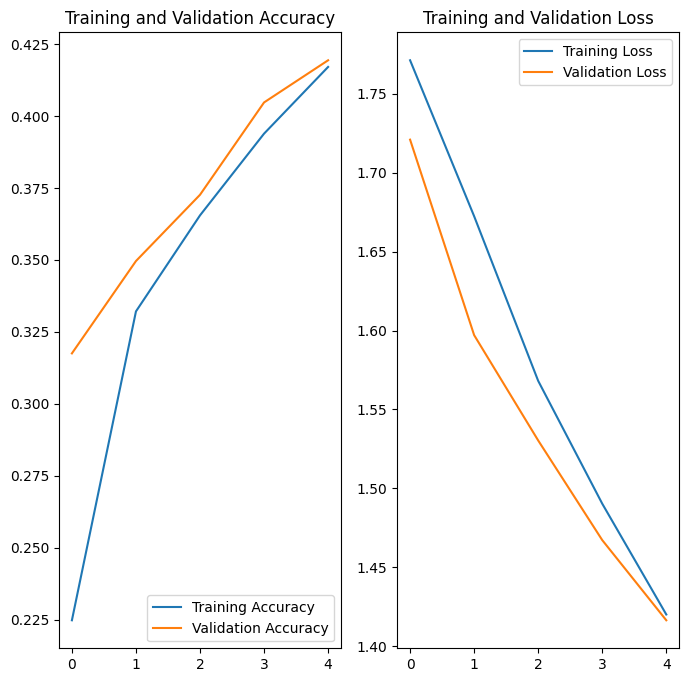

In [ ]:
plot_history(history_hp, 5)

#### Discussion

By the validation results, the hypertuning looks to have yielded one of our best yet, if not the best.

The above plot of its training and validation accuracies by epoch suggests that this model could well benefit from further epochs, as the curves have not yet plateaued. In this next section, I make just that adjustment and train the same architecture with more epochs.

### Model 6 - Adding Epochs

#### Create and train model

In [ ]:
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)

In [ ]:
# model_hp_more_eps = tuner.hypermodel.build(best_hps)
# model_hp_more_eps._name = 'M6.HpWithMoreEps'
# model_hp_more_eps.summary()

# history_hp_more_eps = model_hp_more_eps.fit(train_data_gen,
#                                             steps_per_epoch=train_steps,
#                                             validation_data=val_data_gen,
#                                             validation_steps=val_steps,
#                                             epochs=15,
#                                             callbacks=[stop_early])




```
Model: "M6.HpWithMoreEps"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
=================================================================
 conv2d_6 (Conv2D)           (None, 64, 64, 8)         224       
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 32, 32, 8)         0         
 g2D)                                                            
                                                                 
 conv2d_7 (Conv2D)           (None, 32, 32, 16)        1168      
                                                                 
 max_pooling2d_7 (MaxPoolin  (None, 16, 16, 16)        0         
 g2D)                                                            
                                                                 
 conv2d_8 (Conv2D)           (None, 16, 16, 32)        4640      
                                                                 
 max_pooling2d_8 (MaxPoolin  (None, 8, 8, 32)          0         
 g2D)                                                            
                                                                 
 flatten_2 (Flatten)         (None, 2048)              0         
                                                                 
 dense_8 (Dense)             (None, 128)               262272    
                                                                 
 dense_9 (Dense)             (None, 128)               16512     
                                                                 
 dense_10 (Dense)            (None, 32)                4128      
                                                                 
 dense_11 (Dense)            (None, 6)                 198       
                                                                 
=================================================================
Total params: 289142 (1.10 MB)
Trainable params: 289142 (1.10 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/15
180/180 [==============================] - 54s 291ms/step - loss: 1.4943 - accuracy: 0.3730 - val_loss: 1.1606 - val_accuracy: 0.5527
Epoch 2/15
180/180 [==============================] - 53s 297ms/step - loss: 0.9439 - accuracy: 0.6267 - val_loss: 0.8397 - val_accuracy: 0.6609
Epoch 3/15
180/180 [==============================] - 53s 293ms/step - loss: 0.6566 - accuracy: 0.7536 - val_loss: 0.6840 - val_accuracy: 0.7425
Epoch 4/15
180/180 [==============================] - 53s 294ms/step - loss: 0.4858 - accuracy: 0.8182 - val_loss: 0.5649 - val_accuracy: 0.7809
Epoch 5/15
180/180 [==============================] - 50s 275ms/step - loss: 0.3736 - accuracy: 0.8615 - val_loss: 0.4392 - val_accuracy: 0.8332
Epoch 6/15
180/180 [==============================] - 49s 271ms/step - loss: 0.2747 - accuracy: 0.9039 - val_loss: 0.3871 - val_accuracy: 0.8590
Epoch 7/15
180/180 [==============================] - 55s 303ms/step - loss: 0.2126 - accuracy: 0.9246 - val_loss: 0.4174 - val_accuracy: 0.8451
Epoch 8/15
180/180 [==============================] - 51s 284ms/step - loss: 0.1661 - accuracy: 0.9387 - val_loss: 0.3198 - val_accuracy: 0.8842
Epoch 9/15
180/180 [==============================] - 54s 298ms/step - loss: 0.1516 - accuracy: 0.9454 - val_loss: 0.3667 - val_accuracy: 0.8758
Epoch 10/15
180/180 [==============================] - 53s 294ms/step - loss: 0.1139 - accuracy: 0.9576 - val_loss: 0.3858 - val_accuracy: 0.8702
Epoch 11/15
180/180 [==============================] - 53s 292ms/step - loss: 0.0719 - accuracy: 0.9762 - val_loss: 0.3440 - val_accuracy: 0.8904
Epoch 12/15
180/180 [==============================] - 53s 293ms/step - loss: 0.0830 - accuracy: 0.9725 - val_loss: 0.3805 - val_accuracy: 0.8779
Epoch 13/15
180/180 [==============================] - 51s 285ms/step - loss: 0.0737 - accuracy: 0.9740 - val_loss: 0.3580 - val_accuracy: 0.8814
```



In [ ]:
# model_hp_more_eps.save('model_hp_more_eps.keras')
# pickle_to_file(history_hp_more_eps, 'model_hp_more_eps_history.pickle')

#### (Load model from file)

In [ ]:
model_hp_more_eps = tf.keras.models.load_model('model_hp_more_eps.keras')
history_hp_more_eps = unpickle_from_file('model_hp_more_eps_history.pickle')

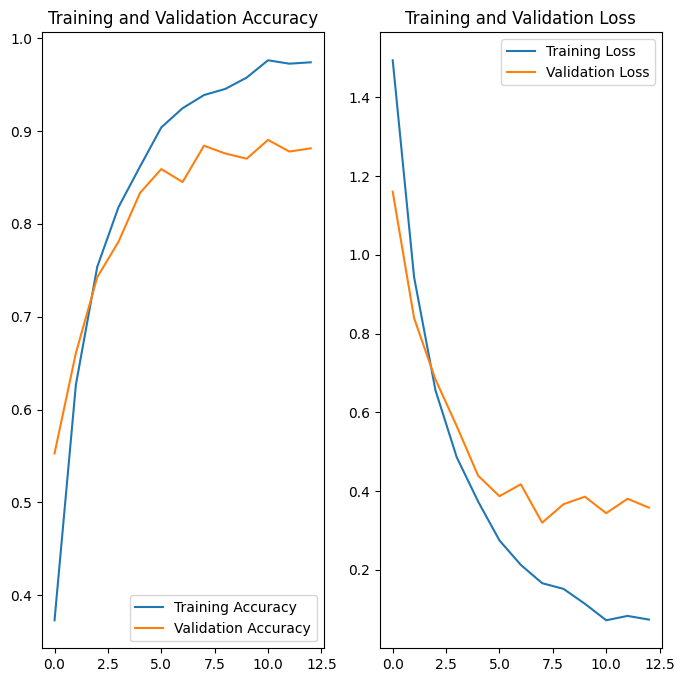

In [ ]:
plot_history(history_hp_more_eps, 13)

#### Discussion

The graph above clearly indicates substantial overfitting, taking place at the 5th epoch or near it. Given this, I wonder if it might perform quite similarly to the previous model, 'M5', which had the same architecture but was instead only trained for 5 epochs.

## BATCH NORMALIZATION

Here we try out a CNN that utilizes both dropout layers and batch normalization. Perhaps the resulting model might be less overfit than the last (the 13-epoch model #6).

### Model 7

#### Create model

In [ ]:
model_7 = Sequential()

model_7.add(Conv2D(32, (3, 3), activation='relu', input_shape=INPUT_SHAPE))
model_7.add(BatchNormalization())
model_7.add(MaxPooling2D(pool_size=(3, 3)))
model_7.add(Dropout(0.15))

model_7.add(Conv2D(64, (3, 3), activation='relu'))
model_7.add(BatchNormalization())
model_7.add(MaxPooling2D(pool_size=(2, 2)))
model_7.add(Dropout(0.15))

model_7.add(Conv2D(128, (3, 3), activation='relu'))
model_7.add(BatchNormalization())
model_7.add(MaxPooling2D(pool_size=(3, 3)))
model_7.add(Dropout(0.15))

model_7.add(Flatten())
model_7.add(Dense(128, activation='relu'))
model_7.add(BatchNormalization())
model_7.add(Dense(64, activation='relu'))
model_7.add(BatchNormalization())
model_7.add(Dense(32, activation='relu'))
model_7.add(BatchNormalization())
model_7.add(Dropout(0.15))
model_7.add(Dense(6, activation='softmax'))

model_7._name = 'M7.1stBatchNorm'

model_7.summary()

model_7.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])

Model: "M7.1stBatchNorm"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 62, 62, 32)        896       
                                                                 
 batch_normalization (Batch  (None, 62, 62, 32)        128       
 Normalization)                                                  
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 20, 20, 32)        0         
 g2D)                                                            
                                                                 
 dropout (Dropout)           (None, 20, 20, 32)        0         
                                                                 
 conv2d_4 (Conv2D)           (None, 18, 18, 64)        18496     
                                                                 
 batch_normalization_1 (Bat  (None, 18, 18, 64)    

#### Train model

In [ ]:
# stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)

# train_time_start = time.time()

# history = model_7.fit(
#     train_data_gen,
#     steps_per_epoch=train_steps,
#     epochs=15,
#     validation_data=val_data_gen,
#     validation_steps=val_steps,
#     callbacks=[stop_early]
# )

# train_time_M7 = time.time() - train_time_start
# print(f"Training time: {train_time_M7} seconds")



```
Epoch 1/15
180/180 [==============================] - 81s 436ms/step - loss: 1.9882 - accuracy: 0.2133 - val_loss: 1.7807 - val_accuracy: 0.2128
Epoch 2/15
180/180 [==============================] - 80s 444ms/step - loss: 1.6414 - accuracy: 0.3282 - val_loss: 1.8217 - val_accuracy: 0.2387
Epoch 3/15
180/180 [==============================] - 78s 432ms/step - loss: 1.4285 - accuracy: 0.4210 - val_loss: 1.7662 - val_accuracy: 0.3419
Epoch 4/15
180/180 [==============================] - 80s 446ms/step - loss: 1.2614 - accuracy: 0.4998 - val_loss: 1.2948 - val_accuracy: 0.4759
Epoch 5/15
180/180 [==============================] - 78s 432ms/step - loss: 1.1176 - accuracy: 0.5552 - val_loss: 1.1766 - val_accuracy: 0.5527
Epoch 6/15
180/180 [==============================] - 80s 446ms/step - loss: 1.0127 - accuracy: 0.6046 - val_loss: 0.9342 - val_accuracy: 0.6322
Epoch 7/15
180/180 [==============================] - 79s 439ms/step - loss: 0.9293 - accuracy: 0.6416 - val_loss: 0.9887 - val_accuracy: 0.6197
Epoch 8/15
180/180 [==============================] - 79s 437ms/step - loss: 0.8423 - accuracy: 0.6753 - val_loss: 1.0659 - val_accuracy: 0.6092
Epoch 9/15
180/180 [==============================] - 80s 443ms/step - loss: 0.7806 - accuracy: 0.7019 - val_loss: 0.7992 - val_accuracy: 0.7020
Epoch 10/15
180/180 [==============================] - 78s 430ms/step - loss: 0.7106 - accuracy: 0.7273 - val_loss: 0.6172 - val_accuracy: 0.7641
Epoch 11/15
180/180 [==============================] - 81s 448ms/step - loss: 0.6850 - accuracy: 0.7407 - val_loss: 0.7712 - val_accuracy: 0.7090
Epoch 12/15
180/180 [==============================] - 83s 458ms/step - loss: 0.6416 - accuracy: 0.7585 - val_loss: 0.6062 - val_accuracy: 0.7760
Epoch 13/15
180/180 [==============================] - 80s 444ms/step - loss: 0.5983 - accuracy: 0.7759 - val_loss: 0.7811 - val_accuracy: 0.6895
Epoch 14/15
180/180 [==============================] - 78s 435ms/step - loss: 0.5560 - accuracy: 0.7959 - val_loss: 0.4820 - val_accuracy: 0.8165
Epoch 15/15
180/180 [==============================] - 80s 445ms/step - loss: 0.5129 - accuracy: 0.8116 - val_loss: 0.4522 - val_accuracy: 0.8151
Training time: 1206.4812424182892 seconds
```



In [ ]:
# model_7.save('model_7.keras')
# pickle_to_file(history, 'model_7_history.pickle')

#### (Load model from file)

In [ ]:
model_7 = tf.keras.models.load_model('model_7.keras')
history_7 = unpickle_from_file('model_7_history.pickle')

In [ ]:
val_loss, val_acc = model_7.evaluate(val_data_gen)

23/23 [==============================] - 5s 200ms/step - loss: 0.4522 - accuracy: 0.8151


In [ ]:
train_loss, train_acc = model_7.evaluate(train_data_gen)

180/180 [==============================] - 43s 240ms/step - loss: 0.3312 - accuracy: 0.8825


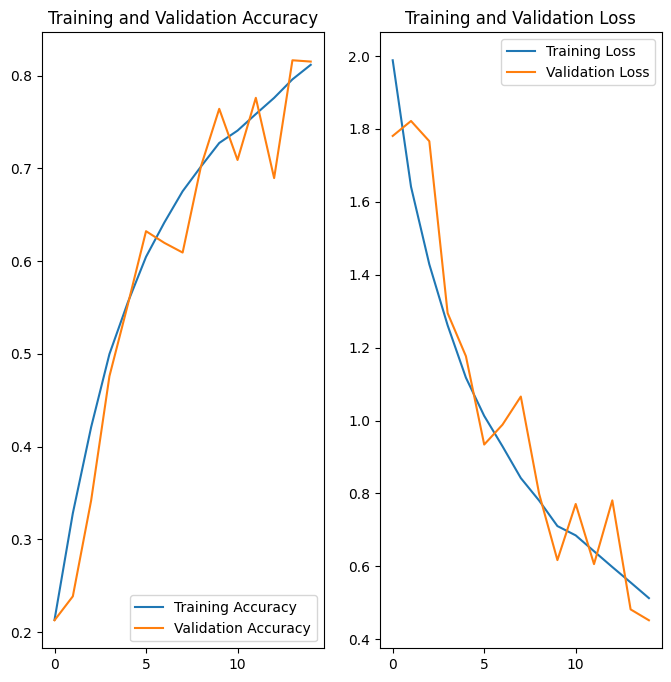

In [ ]:
plot_history(history_7, 15)

#### Discussion

This model could have benefitted from more epochs in training, judging by these plots. I expected that the 15 epochs I entered would have been enough, but was mistaken.

I would rerun with more epochs, but this already took 20 minutes. If I have more time later, I will come back and do so.

### Model 8

#### Create model

In [ ]:
model_8 = Sequential()

model_8.add(Conv2D(32, (3, 3), activation='relu', input_shape=INPUT_SHAPE))
model_8.add(BatchNormalization())
model_8.add(MaxPooling2D(pool_size=(3, 3)))
model_8.add(Dropout(0.15))

model_8.add(Conv2D(64, (3, 3), activation='relu'))
model_8.add(BatchNormalization())
model_8.add(MaxPooling2D(pool_size=(2, 2)))
model_8.add(Dropout(0.15))

model_8.add(Conv2D(128, (3, 3), activation='relu'))
model_8.add(BatchNormalization())
model_8.add(MaxPooling2D(pool_size=(3, 3)))
model_8.add(Dropout(0.15))

model_8.add(Flatten())
model_8.add(Dense(64, activation='relu'))
model_8.add(BatchNormalization())
model_8.add(Dropout(0.15))
model_8.add(Dense(6, activation='softmax'))

model_8._name = 'M8.2ndBatchNorm'

model_8.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])

model_8.summary()

Model: "M8.2ndBatchNorm"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 62, 62, 32)        896       
                                                                 
 batch_normalization_6 (Bat  (None, 62, 62, 32)        128       
 chNormalization)                                                
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 20, 20, 32)        0         
 g2D)                                                            
                                                                 
 dropout_4 (Dropout)         (None, 20, 20, 32)        0         
                                                                 
 conv2d_7 (Conv2D)           (None, 18, 18, 64)        18496     
                                                                 
 batch_normalization_7 (Bat  (None, 18, 18, 64)    

#### Train model

In [ ]:
# stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)

# train_time_start = time.time()

# history = model_8.fit(
#     train_data_gen,
#     steps_per_epoch=train_steps,
#     epochs=15,
#     validation_data=val_data_gen,
#     validation_steps=val_steps,
#     callbacks=[stop_early]
# )

# train_time_M8 = time.time() - train_time_start
# print(f"Training time: {train_time_M8} seconds")



```
Epoch 1/15
180/180 [==============================] - 84s 452ms/step - loss: 1.8881 - accuracy: 0.2445 - val_loss: 2.5073 - val_accuracy: 0.1675
Epoch 2/15
180/180 [==============================] - 85s 470ms/step - loss: 1.5585 - accuracy: 0.3812 - val_loss: 2.1553 - val_accuracy: 0.2226
Epoch 3/15
180/180 [==============================] - 83s 460ms/step - loss: 1.3232 - accuracy: 0.4751 - val_loss: 1.3681 - val_accuracy: 0.4669
Epoch 4/15
180/180 [==============================] - 85s 471ms/step - loss: 1.1433 - accuracy: 0.5479 - val_loss: 1.2942 - val_accuracy: 0.5017
Epoch 5/15
180/180 [==============================] - 85s 472ms/step - loss: 1.0158 - accuracy: 0.6111 - val_loss: 1.2182 - val_accuracy: 0.5394
Epoch 6/15
180/180 [==============================] - 84s 467ms/step - loss: 0.9112 - accuracy: 0.6483 - val_loss: 0.9144 - val_accuracy: 0.6602
Epoch 7/15
180/180 [==============================] - 89s 495ms/step - loss: 0.8417 - accuracy: 0.6796 - val_loss: 0.8143 - val_accuracy: 0.6930
Epoch 8/15
180/180 [==============================] - 84s 467ms/step - loss: 0.7784 - accuracy: 0.7036 - val_loss: 0.7904 - val_accuracy: 0.6999
Epoch 9/15
180/180 [==============================] - 84s 467ms/step - loss: 0.7205 - accuracy: 0.7231 - val_loss: 0.7386 - val_accuracy: 0.7258
Epoch 10/15
180/180 [==============================] - 81s 450ms/step - loss: 0.6748 - accuracy: 0.7480 - val_loss: 0.5987 - val_accuracy: 0.7795
Epoch 11/15
180/180 [==============================] - 87s 479ms/step - loss: 0.6257 - accuracy: 0.7679 - val_loss: 0.6123 - val_accuracy: 0.7669
Epoch 12/15
180/180 [==============================] - 87s 483ms/step - loss: 0.5879 - accuracy: 0.7762 - val_loss: 0.5533 - val_accuracy: 0.7934
Epoch 13/15
180/180 [==============================] - 87s 483ms/step - loss: 0.5700 - accuracy: 0.7860 - val_loss: 0.7535 - val_accuracy: 0.7202
Epoch 14/15
180/180 [==============================] - 88s 487ms/step - loss: 0.5208 - accuracy: 0.8048 - val_loss: 0.5695 - val_accuracy: 0.7927
Epoch 15/15
180/180 [==============================] - 84s 466ms/step - loss: 0.4928 - accuracy: 0.8204 - val_loss: 0.4769 - val_accuracy: 0.8241
Training time: 1840.2857513427734 seconds
```



In [ ]:
# model_8.save('model_8.keras')
# pickle_to_file(history, 'model_8_history.pickle')

#### (Load model from file)

In [ ]:
model_8 = tf.keras.models.load_model('model_8.keras')
model_8_history = unpickle_from_file('model_8_history.pickle')

In [ ]:
val_loss, val_acc = model_8.evaluate(val_data_gen)

23/23 [==============================] - 5s 194ms/step - loss: 0.4769 - accuracy: 0.8241


In [ ]:
train_loss, train_acc = model_8.evaluate(train_data_gen)

180/180 [==============================] - 43s 237ms/step - loss: 0.2864 - accuracy: 0.9019


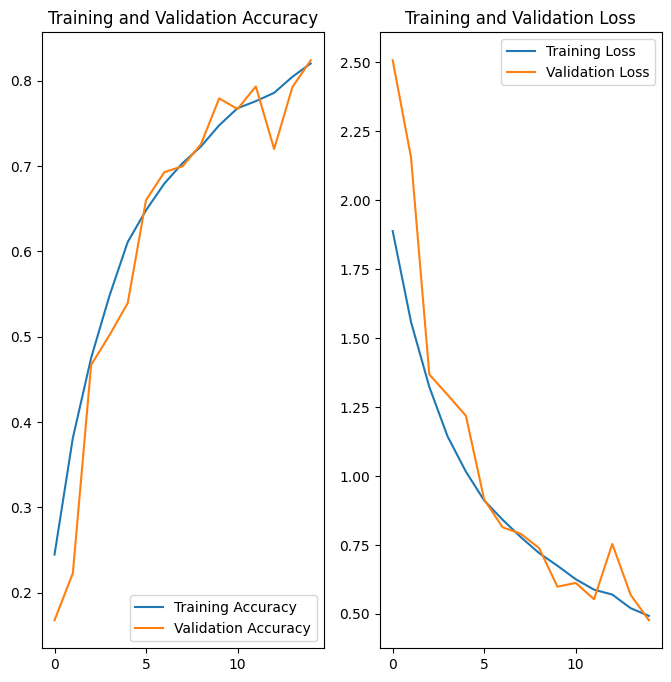

In [ ]:
plot_history(model_8_history, 15)

#### Discussion

Like the previous model, this one probably could have benefitted from more epochs in training. But at 15 epochs, its training was already as long as 30 minutes.

## EVALUATING MODELS

### VALIDATION

##### Create table for validation results

In [ ]:
val_results = pd.DataFrame({'model':[],
                           'val_accuracy':[],
                           'val_f1':[],
                           'val_recall':[],
                           'val_precision':[]
                           })
val_results.T

""
model
val_accuracy
val_f1
val_recall
val_precision


##### **eval_performance** function

In [ ]:
def eval_performance(val_data, model, record=False, ConfMatrix=True):
  ''' Validates model on given set (generator) and plots confusion matrix. '''
  VAL_SIZE = val_data.samples
  BATCH_SIZE = val_data.batch_size
  steps = np.ceil(VAL_SIZE/BATCH_SIZE)

  val_pred_probas = model.predict(val_data, steps=steps)
  val_preds = np.argmax(val_pred_probas, axis=1)
  conf_matrix = confusion_matrix(val_data.classes, val_preds)

  target_names = ['Anger', 'Disgust', 'Fear', 'Happiness', 'Neutral', 'Sadness']


  if ConfMatrix:
    print('\n\n', classification_report(val_data.classes, val_preds,
                                      target_names=target_names))

    plot_confusion_matrix_heatmap(conf_matrix, target_names)

  if record:


    # Make classification report dictionary to  get f1, recall, and precision
    val_class_dict = classification_report(val_data.classes, val_preds,
                                          target_names=target_names,
                                          output_dict=True, zero_division=0)

    val_acc = val_class_dict['accuracy']
    val_w_avg_f1 = val_class_dict['weighted avg']['f1-score']
    val_w_avg_recall = val_class_dict['weighted avg']['recall']
    val_w_avg_precision = val_class_dict['weighted avg']['precision']



    return [model._name, val_acc, val_w_avg_f1, val_w_avg_recall,
            val_w_avg_precision]

#### Recreating generators that correspond to each model

In [ ]:
borrowed_cnn_val_gen = validation_image_generator.flow_from_directory(
    validate_dir,
    target_size=(128, 128),
    batch_size=256,
    class_mode='categorical',
    shuffle=False
)

CNN_P6_val_gen = validation_image_generator.flow_from_directory(
    validate_dir,
    target_size=(128, 128),
    batch_size=2048,
    class_mode='categorical',
    shuffle=False
)

model_4_val_gen = validation_image_generator.flow_from_directory(
    validate_dir,
    target_size=(64, 64),
    batch_size=2048,
    class_mode='categorical',
    shuffle=False
)

else_val_gen = validation_image_generator.flow_from_directory(
    validate_dir,
    target_size=(64, 64),
    batch_size=64,
    class_mode='categorical',
    shuffle=False
)

Found 1433 images belonging to 6 classes.
Found 1433 images belonging to 6 classes.
Found 1433 images belonging to 6 classes.
Found 1433 images belonging to 6 classes.


#### Evaluating models and logging results

In [ ]:
for i, filename in enumerate(os.listdir()):
  if filename.endswith('.keras'):
    print(filename)

model_CNN_quick_2.keras
model_7.keras
model_8.keras
model_4.keras
CNN_P6.keras
borrowed_cnn.keras
model_hp.keras
model_hp_more_eps.keras


In [ ]:
for i, filename in enumerate(os.listdir()):
  if filename.endswith('.keras'):
    the_val_gen = None
    match filename:
      case 'borrowed_cnn.keras':
        the_val_gen = borrowed_cnn_val_gen
      case 'CNN_P6.keras':
        the_val_gen = CNN_P6_val_gen
      case 'model_4.keras':
        the_val_gen = model_4_val_gen
      case _:
        the_val_gen = else_val_gen

    model = tf.keras.models.load_model(filename)
    val_results.loc[i] = eval_performance(the_val_gen, model, record=True,
                                          ConfMatrix=False)
# print('\n\n')
# val_results

23/23 [==============================] - 4s 172ms/step


In [ ]:
val_results.sort_values('val_accuracy', ascending=False)

,model,val_accuracy,val_f1,val_recall,val_precision
19,M6.HpWithMoreEps,0.881368,0.881177,0.881368,0.883137
3,M3.LowerImgSz,0.836008,0.835360,0.836008,0.840543
10,M8.2ndBatchNorm,0.824145,0.824097,0.824145,0.838287
18,M5.Hypertuned,0.824145,0.824163,0.824145,0.826092
6,M7.1stBatchNorm,0.815073,0.813292,0.815073,0.824703
15,M1.BorrowedCNN,0.562456,0.561511,0.562456,0.570167
12,M4.LowImgSzHighBatch,0.419400,0.390304,0.419400,0.450850
13,M2.BatchSz2048xCNNp6,0.394976,0.375137,0.394976,0.407659


#### Discussion

In validation, our sixth model, 'M6.HpWithMoreEps,' was our most accurate one by a substantial margin of almost 5%. This might not be a surprising result, since this model is the product of several incremental refinements, ones central to this project:
1. It shares the architecture of the "Project 6 CNN" (CNNp6)
2. It is trained off the lower-resolution images which were found to improve both runtime and accuracy convergence, seemingly.
3. It uses the parameters that were identified as optimal in the hypertuning that led to model "M5.Hypertuned."
4. It was trained with more epochs than most models here (13 after early stopping) after it was indicated in the M5 accuracy plot indicated that this would be beneficial.

This refined, hypertuned model was followed by several others which scored around 82%. These include the first hypertuned model (only 5 epochs) as well as both models from the 'BATCH NORMALIZATION' section. It will be interesting to see which models come up on top in the test validation to follow.

### TEST

##### Create table for validation results

In [ ]:
test_results = pd.DataFrame({'model':[],
                           'test_accuracy':[],
                           'test_f1':[],
                           'test_recall':[],
                           'test_precision':[]
                           })
test_results.T

""
model
test_accuracy
test_f1
test_recall
test_precision


#### Recreating test generators

In [ ]:
borrowed_cnn_test_gen = test_image_generator.flow_from_directory(
    test_dir,
    target_size=(128, 128),
    batch_size=256,
    class_mode='categorical',
    shuffle=False
)

CNN_P6_test_gen = test_image_generator.flow_from_directory(
    test_dir,
    target_size=(128, 128),
    batch_size=2048,
    class_mode='categorical',
    shuffle=False
)

model_4_test_gen = test_image_generator.flow_from_directory(
    test_dir,
    target_size=(64, 64),
    batch_size=2048,
    class_mode='categorical',
    shuffle=False
)

else_test_gen = test_image_generator.flow_from_directory(
    test_dir,
    target_size=(64, 64),
    batch_size=64,
    class_mode='categorical',
    shuffle=False
)

Found 1438 images belonging to 6 classes.
Found 1438 images belonging to 6 classes.
Found 1438 images belonging to 6 classes.
Found 1438 images belonging to 6 classes.


#### Evaluating models and logging results

In [ ]:
for i, filename in enumerate(os.listdir()):
  if filename.endswith('.keras'):
    the_test_gen = None
    match filename:
      case 'borrowed_cnn.keras':
        the_test_gen = borrowed_cnn_test_gen
      case 'CNN_P6.keras':
        the_test_gen = CNN_P6_test_gen
      case 'model_4.keras':
        the_test_gen = model_4_test_gen
      case _:
        the_test_gen = else_test_gen

    model = tf.keras.models.load_model(filename)
    test_results.loc[i] = eval_performance(the_test_gen, model, record=True,
                                          ConfMatrix=False)
# print('\n\n')
# test_results

23/23 [==============================] - 4s 174ms/step


In [ ]:
test_results.sort_values('test_accuracy', ascending=False)

,model,test_accuracy,test_f1,test_recall,test_precision
19,M6.HpWithMoreEps,0.883866,0.883046,0.883866,0.884719
6,M7.1stBatchNorm,0.842837,0.841084,0.842837,0.847643
18,M5.Hypertuned,0.840056,0.839858,0.840056,0.841454
3,M3.LowerImgSz,0.838665,0.837181,0.838665,0.843624
10,M8.2ndBatchNorm,0.821280,0.821574,0.821280,0.836168
15,M1.BorrowedCNN,0.575800,0.571514,0.575800,0.582705
12,M4.LowImgSzHighBatch,0.393602,0.361036,0.393602,0.413439
13,M2.BatchSz2048xCNNp6,0.385257,0.360355,0.385257,0.387889


In [ ]:
val_results.sort_values('val_accuracy', ascending=False)

,model,val_accuracy,val_f1,val_recall,val_precision
19,M6.HpWithMoreEps,0.881368,0.881177,0.881368,0.883137
3,M3.LowerImgSz,0.836008,0.835360,0.836008,0.840543
10,M8.2ndBatchNorm,0.824145,0.824097,0.824145,0.838287
18,M5.Hypertuned,0.824145,0.824163,0.824145,0.826092
6,M7.1stBatchNorm,0.815073,0.813292,0.815073,0.824703
15,M1.BorrowedCNN,0.562456,0.561511,0.562456,0.570167
12,M4.LowImgSzHighBatch,0.419400,0.390304,0.419400,0.450850
13,M2.BatchSz2048xCNNp6,0.394976,0.375137,0.394976,0.407659


#### Discussion

The advantage in accuracy enjoyed by the refined, hypertuned model ('M6.HpWithMoreEps') off the validation set held consistent in the results off the testing set. This model again enjoys a substantial lead over the others.

The group of four models that were just behind 'M6' in validation are in the same position here, though the placements within this group has changed. The first model from the 'BATCH NORMALIZATION' section ('M7.1stBatchNorm) is now the highest in this group and it is more accurate than its section-mate 'M8' by ~2%.



## BEST MODEL'S PREDICTIONS

### CONFUSION MATRIX

23/23 [==============================] - 6s 259ms/step


               precision    recall  f1-score   support

       Anger       0.96      0.95      0.96       237
     Disgust       0.84      0.98      0.91       237
        Fear       0.85      0.78      0.82       241
   Happiness       0.87      0.87      0.87       241
     Neutral       0.89      0.85      0.87       241
     Sadness       0.89      0.87      0.88       241

    accuracy                           0.88      1438
   macro avg       0.88      0.88      0.88      1438
weighted avg       0.88      0.88      0.88      1438



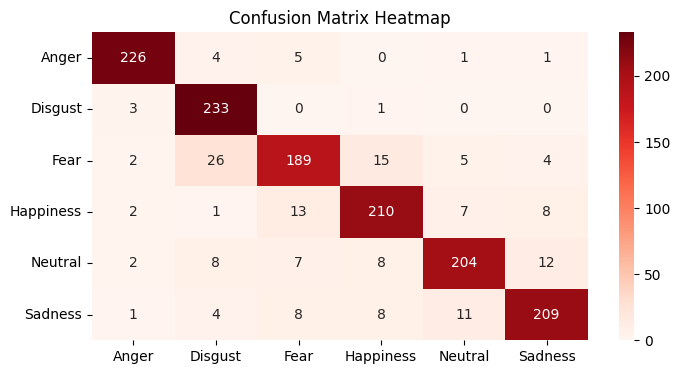

In [ ]:
best_model = tf.keras.models.load_model('model_hp_more_eps.keras')
eval_performance(else_test_gen, best_model)

Judging by this confusion matrix, a few of the most common misclassifications were the following:

- Fear misclassified as disgust.
- Fear misclassified as Happiness.
- Happiness misclassified as fear.

So fear and Happiness were confused for each other, both ways, by this classifier. I wonder if this might be because those emotions are both very high energy. Expressions of those emotions might also share a wide-eyed facial expression.

Fear and disgust might be a pain point because those emotions are commonly combined. So perhaps it's difficult to describe a combined expression of fear and disgust as purely on or the other.



## CONCLUSIONS

The main findings:
  - Lowering the image size to 64x64 rather than our initial setting of 128x128 not only helped the runtimes considerably, but also consistently resulted in more accurate models.
    - As a side note, our efforts to improve runtimes by raising the batch size were mostly in vain: these only ever resulted in  marginal decreases in runtime and they also typically costed the accuracy considerably. (This was the case for our model named 'M4.LowImgSzHighBatch'.)

  -  Regularization measures like DropOut layers and BatchNormalization layers appear to have greatly benefitted the models where we implemented them. Our model 'M7.1stBatchNorm' was our second-best in test accuracy. Just as a well-regularized model might, its validation accuracy wasn't the flashiest of the bunch, but this model was flashy where it mattered most, in its test performance.

  - Some hypertuning efforts determined that it was beneficial to add width to the second hidden layer (of four in that model) while keeping the third and the Adam learning rate consistent. This was a similar optimal scenario to what Max found in his homework for Project 6, so he might look first to widening such second layers in similar future projects.

## FUTURE WORK

Some things we would try if we had more time:

- To further improve our best model, we would try adding some of the regularization measures into it.

- To further hone in on the specific shortfalls of our best classifier, we would have like to visualize some cases of the most common misclassifications, particularly those where fear and happiness were confused for each other.

- In a separate Colab notebook, we successfully trained and tested a couple models from grayscaled versions of the images. Unfortunately, we are disappointed to have run out of time- the deadline is too close to successfully merge that work into this notebook.

- We would have been interested to try an even smaller image size, to gain a sense of where the line is: how few pixels is too costly when it comes to interpreting emotions from facial expressions?

- There were one or two models that looked likely to benefit from 10 more epochs in training, but that would have taken 20-30 minutes each.

# ZIP FILES FOR BACKUP

In [ ]:
# !zip -r /content/GroupProj_Files-6-10-815PM.zip /content/*.keras /content/*pickle